In [ ]:
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(rjson)
library(cowplot)
library(patchwork)

In [3]:
gene_id_map = fread('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/gene_randmol_lookup.csv', sep='\t')
sorted_cell_types = c('B', 'CD4T', 'CD8T', 'NK', 'monocyte', 'DC')
sorted_cell_names = c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC')

In [4]:
head(gene_id_map)

GENEID          GENENAME MOLID       
1 ENSG00000188976 NOC2L    ILMN_1792820
2 ENSG00000187608 ISG15    ILMN_2054019
3 ENSG00000186827 TNFRSF4  ILMN_1710204
4 ENSG00000078808 SDF4     ILMN_1696065
5 ENSG00000131584 ACAP3    ILMN_1743847
6 ENSG00000127054 CPSF3L   ILMN_1718013

In [5]:
omega_shrink = 0.9
max_hsq = 0.8
egenes_dict = fromJSON(file=sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/randMols_lowres_egenes_1e-5_hij0.0001.json',
                                   omega_shrink, max_hsq))    
neutro_egenes_dict = fromJSON(file='/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_neutrophil_egenes_1e-5_hij0.0001.json')

# Nuclear, cytoplasm, ER

In [245]:
gene_list = c('ACTA2', 'AHI1', 'BACH2', 'BATF3', 'CCDC85B', 'CENPU', 'CENPW', 'CTSW', 'DDX6', 'DGKQ', 'DRAP1', 'ETS1', 'ETV7',
             'FIBP', 'GATA3', 'GPX1', 'HHEX', 'IRF7', 'JAZF1', 'LBH', 'LYST', 'MPHOSPH9', 'NCKIPSD', 'NUTF2', 'PHF5A', 'PLCL1',
             'PPP5C', 'PRKCB', 'RGS14', 'RPS26', 'SESN3', 'SHMT1', 'SKAP2', 'SLC2A4RG', 'SNRPC', 'SP140', 'UBASH3A', 'UBE2L3',
             'ULK3', 'XBP1', 'ZFP36L1', 'ZFP90', 'ZNF652')

## PBMC and neutrophil

In [248]:
## pbmc
all_ibsep_egene_ids = c()
all_sc_egene_ids = c()
all_sc2_egene_ids = c()
for(ct in names(egenes_dict)){
    all_ibsep_egene_ids = c(all_ibsep_egene_ids, egenes_dict[[ct]][['1M-Blood-IBSEP']])
    all_sc_egene_ids = c(all_sc_egene_ids, egenes_dict[[ct]][['1M-Blood']])
    all_sc2_egene_ids = c(all_sc2_egene_ids, egenes_dict[[ct]][['OneK1K']])
}
all_ibsep_egene_ids = unique(all_ibsep_egene_ids)
all_sc_egene_ids = unique(all_sc_egene_ids)
all_sc2_egene_ids = unique(all_sc2_egene_ids)
print(length(all_ibsep_egene_ids))
print(length(all_sc_egene_ids))
print(length(all_sc2_egene_ids))

## neutrophil
neutro_ibsep_egene_ids = c()
neutro_sc_egene_ids = c()
neutro_sc2_egene_ids = c()
for(ct in names(egenes_dict)){
    neutro_ibsep_egene_ids = c(neutro_ibsep_egene_ids, neutro_egenes_dict[['IBSEP']])
    neutro_sc_egene_ids = c(neutro_sc_egene_ids, neutro_egenes_dict[['Neutro2015']])
    neutro_sc2_egene_ids = c(neutro_sc2_egene_ids, neutro_egenes_dict[['BLUEPRINT']])
}
neutro_ibsep_egene_ids = unique(neutro_ibsep_egene_ids)
neutro_sc_egene_ids = unique(neutro_sc_egene_ids)
neutro_sc2_egene_ids = unique(neutro_sc2_egene_ids)
print(length(neutro_ibsep_egene_ids))
print(length(neutro_sc_egene_ids))
print(length(neutro_sc2_egene_ids))

[1] 1099
[1] 311
[1] 1698
[1] 1950
[1] 426
[1] 1646


In [249]:
### pbmc
## geneid to genename
all_ibsep_egenes = unname(sapply(all_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc_egenes = unname(sapply(all_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc2_egenes = unname(sapply(all_sc2_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(all_ibsep_egenes))
print(length(all_sc_egenes))
print(length(all_sc2_egenes))

## merge egenes with gene list
merged_ibsep_egenes = intersect(gene_list, all_ibsep_egenes)
merged_sc_egenes = intersect(gene_list, all_sc_egenes)
merged_sc2_egenes = intersect(gene_list, all_sc2_egenes)
print(length(merged_ibsep_egenes))
print(length(merged_sc_egenes))
print(length(merged_sc2_egenes))

### neutrophil
## geneid to genename
neutro_ibsep_egenes = unname(sapply(neutro_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
neutro_sc_egenes = unname(sapply(neutro_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
neutro_sc2_egenes = unname(sapply(neutro_sc2_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(neutro_ibsep_egenes))
print(length(neutro_sc_egenes))
print(length(neutro_sc2_egenes))

## merge egenes with gene list
merged_neutro_ibsep_egenes = intersect(gene_list, neutro_ibsep_egenes)
merged_neutro_sc_egenes = intersect(gene_list, neutro_sc_egenes)
merged_neutro_sc2_egenes = intersect(gene_list, neutro_sc2_egenes)
print(length(merged_neutro_ibsep_egenes))
print(length(merged_neutro_sc_egenes))
print(length(merged_neutro_sc2_egenes))

[1] 1099
[1] 311
[1] 1698
[1] 9
[1] 7
[1] 24
[1] 1950
[1] 426
[1] 1646
[1] 9
[1] 3
[1] 7


In [250]:
# 1: shared, positive, 2: novel, positive
# -1: shared, negative, -2: novel, negative
merged_ibsep_sc_egenes = union(merged_ibsep_egenes,merged_sc_egenes)
merged_neutro_ibsep_sc_egenes = union(merged_neutro_ibsep_egenes,merged_neutro_sc_egenes)
pbmc_neutro_ibsep_sc_egenes = union(merged_ibsep_sc_egenes, merged_neutro_ibsep_sc_egenes)
mat = matrix(nrow=length(pbmc_neutro_ibsep_sc_egenes), ncol=length(sorted_cell_types)+1)
for(i in 1:nrow(mat)){
    gene = pbmc_neutro_ibsep_sc_egenes[i]
    gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
    mol_id = gene_id_map[gene_id_map$GENENAME==gene]$MOLID
    for(j in 1:length(sorted_cell_types)){
        ct = sorted_cell_types[j]
        for(chr in 1:22){
            filename = sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct)
            if(file.exists(filename)){
                break
            }
        }
        if(file.exists(filename)){
            eqtl_df = fread(filename, sep='\t') %>%
                dplyr::filter(!is.na(PVAL_BLUE)) %>%
                dplyr::filter(!is.na(PVAL))
            if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
            }else if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & !(gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
            }else if(!(gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
            }else{
                mat[i, j] = 0
            }
            if((gene_id %in% egenes_dict[[ct]][['OneK1K']])){
                mat[i, j] = mat[i, j] * 10
            }
        }else{
            mat[i, j] = 0
        }
    }
    j = ncol(mat)
    ct = 'neutrophil'
    for(chr in 1:22){
        filename = sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                           omega_shrink, max_hsq, chr, gene_id, mol_id, ct)
        if(file.exists(filename)){
            break
        }
    }
    if(file.exists(filename)){
        eqtl_df = fread(filename, sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))
        if((gene_id %in% neutro_egenes_dict[['IBSEP']]) & (gene_id %in% neutro_egenes_dict[['Neutro2015']])){
            mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
        }else if((gene_id %in% neutro_egenes_dict[['IBSEP']]) & !(gene_id %in% neutro_egenes_dict[['Neutro2015']])){
            mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
        }else if(!(gene_id %in% neutro_egenes_dict[['IBSEP']]) & (gene_id %in% neutro_egenes_dict[['Neutro2015']])){
            mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
        }else{
            mat[i, j] = 0
        }
        if((gene_id %in% neutro_egenes_dict[['BLUEPRINT']])){
            mat[i, j] = mat[i, j] * 10
        }
    }else{
        mat[i, j] = 0
    }
}

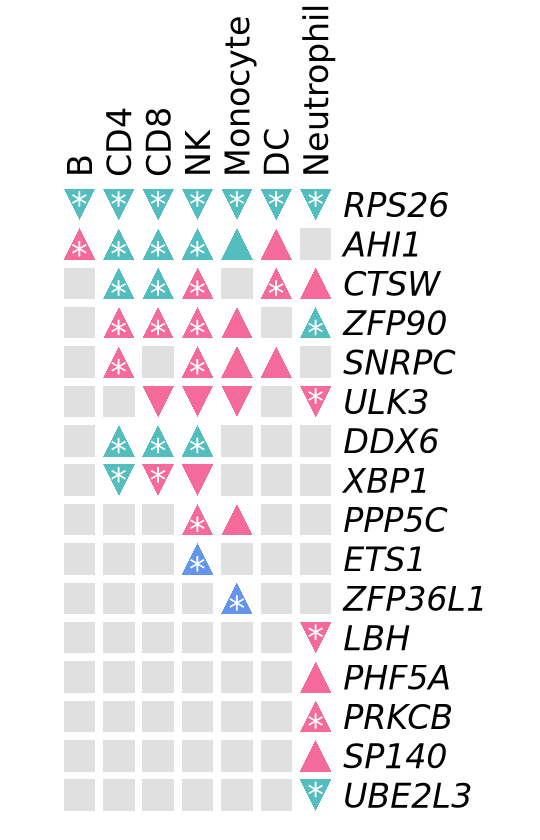

In [253]:
## heatmap
options(repr.plot.width=2.7, repr.plot.height=4.2, repr.plot.res=200)
c0 = "#E0E0E0" # null
c1 = '#54bebe' # shared with sc
c2 = '#f46a9b' # novel in ibsep
c3 = '#7FAFD2' # shared in 1k1k
c4 = '#F69541' # ibsep novel in 1k1k
c5 = '#6495ED' # only in sc
text_color = '#FFFFFF'
col_fun = colorRamp2(c(0, 1, 2, 3), c(c0, c1, c2, c5))
colors = structure(c(c0, c1, c2, c4), names = c(0,1,2,3))
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE, row_order=c(5,1,2,9,6,7,3,8,4,10,11,12,13,14,15,16),
        cell_fun = function(j, i, x, y, width, height, fill) {
            if(mat[i, j]==0){
                grid.rect(x=x, y=y, width=unit(4, 'mm'), height=unit(4, 'mm'),
                         gp = gpar(fill = c0, col = NA))
            }else if(mat[i, j]>0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                if((mat[i, j]==1) | (mat[i, j]==10)){
                    color = col_fun(1)
                }else if((mat[i, j]==2) | (mat[i, j]==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]>=10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)-1.2,'mm'), gp=gpar(col=text_color))
                }    
            }else if(mat[i, j]<0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                if((abs(mat[i, j])==1) | (abs(mat[i, j])==10)){
                    color = col_fun(1)
                }else if((abs(mat[i, j])==2) | (abs(mat[i, j])==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]<=-10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)+0.1,'mm'), gp=gpar(col=text_color))
                }    
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(pbmc_neutro_ibsep_sc_egenes, which='row', 
                                                          gp = gpar(fontsize = 12, fontfamily='ArialMT', fontface = "italic"))),
        top_annotation=columnAnnotation(labels = anno_text(c(sorted_cell_names, 'Neutrophil'), 
                                                              which='column', gp = gpar(fontsize = 12, fontfamily='ArialMT'),
                                                          just='left', location=unit(0, 'npc'))),
        width = w, height = h, column_gap = unit(0, "mm"), border = FALSE, show_column_names=TRUE,
        show_heatmap_legend=FALSE
        )
draw(ht)

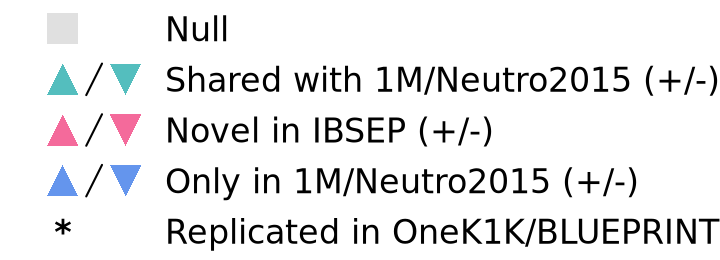

In [267]:
options(repr.plot.width=3.6, repr.plot.height=1.3, repr.plot.res=200)
c0 = "#E0E0E0"
c1 = '#54bebe'
c2 = '#f46a9b'
c5 = '#6495ED'
text_color = '#FFFFFF'
offset = 4
lgd = Legend(labels = c('Null', 'Shared with 1M/Neutro2015 (+/-)', 'Novel in IBSEP (+/-)', 'Only in 1M/Neutro2015 (+/-)', 'Replicated in OneK1K/BLUEPRINT'), 
             ncol=1, column_gap = unit(14, "mm"), row_gap = unit(2, 'mm'),
             legend_gp = gpar(fill = 'orange'),
             labels_gp = gpar(fontsize=12, fontfamily='ArialMT'), grid_width = unit(16, "mm"),
    graphics = list(
        function(x, y, w, h) grid.rect(unit(as.numeric(x)-4,'mm'), y, unit(4, 'mm'), unit(4, 'mm'), gp = gpar(fill = c0, col=NA)),
        function(x, y, w, h) {
            x1 = unit(as.numeric(x)-2-offset,'mm')
            x2 = unit(as.numeric(x)+2-offset,'mm')
            x3 = unit(as.numeric(x)-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)-2,'mm')
            y3 = unit(as.numeric(y)+2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c1, col=NA))
            x1 = unit(as.numeric(x)+3-offset,'mm')
            x2 = unit(as.numeric(x)+5-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            grid.lines(x=c(x1,x2), y=c(y1,y2), default.units='mm')
            x1 = unit(as.numeric(x)+6-offset,'mm')
            x2 = unit(as.numeric(x)+10-offset,'mm')
            x3 = unit(as.numeric(x)+8-offset,'mm')
            y1 = unit(as.numeric(y)+2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            y3 = unit(as.numeric(y)-2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c1, col=NA))
        },
        function(x, y, w, h) {
            x1 = unit(as.numeric(x)-2-offset,'mm')
            x2 = unit(as.numeric(x)+2-offset,'mm')
            x3 = unit(as.numeric(x)-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)-2,'mm')
            y3 = unit(as.numeric(y)+2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c2, col=NA))
            x1 = unit(as.numeric(x)+3-offset,'mm')
            x2 = unit(as.numeric(x)+5-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            grid.lines(x=c(x1,x2), y=c(y1,y2), default.units='mm')
            x1 = unit(as.numeric(x)+6-offset,'mm')
            x2 = unit(as.numeric(x)+10-offset,'mm')
            x3 = unit(as.numeric(x)+8-offset,'mm')
            y1 = unit(as.numeric(y)+2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            y3 = unit(as.numeric(y)-2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c2, col=NA))
        },
        function(x, y, w, h) {
            x1 = unit(as.numeric(x)-2-offset,'mm')
            x2 = unit(as.numeric(x)+2-offset,'mm')
            x3 = unit(as.numeric(x)-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)-2,'mm')
            y3 = unit(as.numeric(y)+2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c5, col=NA))
            x1 = unit(as.numeric(x)+3-offset,'mm')
            x2 = unit(as.numeric(x)+5-offset,'mm')
            y1 = unit(as.numeric(y)-2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            grid.lines(x=c(x1,x2), y=c(y1,y2), default.units='mm')
            x1 = unit(as.numeric(x)+6-offset,'mm')
            x2 = unit(as.numeric(x)+10-offset,'mm')
            x3 = unit(as.numeric(x)+8-offset,'mm')
            y1 = unit(as.numeric(y)+2,'mm')
            y2 = unit(as.numeric(y)+2,'mm')
            y3 = unit(as.numeric(y)-2,'mm')
            grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), 
                         default.units='mm', gp = gpar(fill = c5, col=NA))
        },
        function(x, y, w, h){
            grid.text('*', x=unit(as.numeric(x)-4,'mm'), y=y, 
                      gp=gpar(fill=text_color, fontface='bold'))
        }
    ))
draw(lgd)

# Surface, membrane

In [254]:
gene_list = c('BLK', 'BTN3A1', 'CCR6', 'CD247', 'CD27', 'CD37', 'CD6', 'CD63', 'CD83', 'CLEC2D', 'CLECL1', 'CRHR1', 'CTLA4', 'DSE', 'FCRL3', 
             'GNG8', 'GPR18', 'IFNGR2', 'IL12RB2', 'IL18R1', 'IL2RA', 'ITGA4', 'LRRC37A2', 'LY9', 'MMEL1', 'PTGIR', 'RGS1', 'SCAMP3', 
             'SLC15A2', 'SLC44A2', 'TMEN258', 'TNFRSF14', 'UBE2D3')

## PBMC and neutrophil

In [255]:
## pbmc
all_ibsep_egene_ids = c()
all_sc_egene_ids = c()
all_sc2_egene_ids = c()
for(ct in names(egenes_dict)){
    all_ibsep_egene_ids = c(all_ibsep_egene_ids, egenes_dict[[ct]][['1M-Blood-IBSEP']])
    all_sc_egene_ids = c(all_sc_egene_ids, egenes_dict[[ct]][['1M-Blood']])
    all_sc2_egene_ids = c(all_sc2_egene_ids, egenes_dict[[ct]][['OneK1K']])
}
all_ibsep_egene_ids = unique(all_ibsep_egene_ids)
all_sc_egene_ids = unique(all_sc_egene_ids)
all_sc2_egene_ids = unique(all_sc2_egene_ids)
print(length(all_ibsep_egene_ids))
print(length(all_sc_egene_ids))
print(length(all_sc2_egene_ids))

## neutrophil
neutro_ibsep_egene_ids = c()
neutro_sc_egene_ids = c()
neutro_sc2_egene_ids = c()
for(ct in names(egenes_dict)){
    neutro_ibsep_egene_ids = c(neutro_ibsep_egene_ids, neutro_egenes_dict[['IBSEP']])
    neutro_sc_egene_ids = c(neutro_sc_egene_ids, neutro_egenes_dict[['Neutro2015']])
    neutro_sc2_egene_ids = c(neutro_sc2_egene_ids, neutro_egenes_dict[['BLUEPRINT']])
}
neutro_ibsep_egene_ids = unique(neutro_ibsep_egene_ids)
neutro_sc_egene_ids = unique(neutro_sc_egene_ids)
neutro_sc2_egene_ids = unique(neutro_sc2_egene_ids)
print(length(neutro_ibsep_egene_ids))
print(length(neutro_sc_egene_ids))
print(length(neutro_sc2_egene_ids))

[1] 1099
[1] 311
[1] 1698
[1] 1950
[1] 426
[1] 1646


In [256]:
### pbmc
## geneid to genename
all_ibsep_egenes = unname(sapply(all_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc_egenes = unname(sapply(all_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
all_sc2_egenes = unname(sapply(all_sc2_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(all_ibsep_egenes))
print(length(all_sc_egenes))
print(length(all_sc2_egenes))

## merge egenes with gene list
merged_ibsep_egenes = intersect(gene_list, all_ibsep_egenes)
merged_sc_egenes = intersect(gene_list, all_sc_egenes)
merged_sc2_egenes = intersect(gene_list, all_sc2_egenes)
print(length(merged_ibsep_egenes))
print(length(merged_sc_egenes))
print(length(merged_sc2_egenes))

### neutrophil
## geneid to genename
neutro_ibsep_egenes = unname(sapply(neutro_ibsep_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
neutro_sc_egenes = unname(sapply(neutro_sc_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
neutro_sc2_egenes = unname(sapply(neutro_sc2_egene_ids, function(x){gene_id_map[gene_id_map$GENEID==x]$GENENAME}))
print(length(neutro_ibsep_egenes))
print(length(neutro_sc_egenes))
print(length(neutro_sc2_egenes))

## merge egenes with gene list
merged_neutro_ibsep_egenes = intersect(gene_list, neutro_ibsep_egenes)
merged_neutro_sc_egenes = intersect(gene_list, neutro_sc_egenes)
merged_neutro_sc2_egenes = intersect(gene_list, neutro_sc2_egenes)
print(length(merged_neutro_ibsep_egenes))
print(length(merged_neutro_sc_egenes))
print(length(merged_neutro_sc2_egenes))

[1] 1099
[1] 311
[1] 1698
[1] 4
[1] 0
[1] 11
[1] 1950
[1] 426
[1] 1646
[1] 7
[1] 1
[1] 3


In [257]:
# 1: shared, positive, 2: novel, positive
# -1: shared, negative, -2: novel, negative
merged_ibsep_sc_egenes = union(merged_ibsep_egenes,merged_sc_egenes)
merged_neutro_ibsep_sc_egenes = union(merged_neutro_ibsep_egenes,merged_neutro_sc_egenes)
pbmc_neutro_ibsep_sc_egenes = union(merged_ibsep_sc_egenes, merged_neutro_ibsep_sc_egenes)
mat = matrix(nrow=length(pbmc_neutro_ibsep_sc_egenes), ncol=length(sorted_cell_types)+1)
for(i in 1:nrow(mat)){
    gene = pbmc_neutro_ibsep_sc_egenes[i]
    gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
    mol_id = gene_id_map[gene_id_map$GENENAME==gene]$MOLID
    for(j in 1:length(sorted_cell_types)){
        ct = sorted_cell_types[j]
        for(chr in 1:22){
            filename = sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct)
            if(file.exists(filename)){
                break
            }
        }
        if(file.exists(filename)){
            eqtl_df = fread(filename, sep='\t') %>%
                dplyr::filter(!is.na(PVAL_BLUE)) %>%
                dplyr::filter(!is.na(PVAL))
            if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
            }else if((gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & !(gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
            }else if(!(gene_id %in% egenes_dict[[ct]][['1M-Blood-IBSEP']]) & (gene_id %in% egenes_dict[[ct]][['1M-Blood']])){
                mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
            }else{
                mat[i, j] = 0
            }
            if((gene_id %in% egenes_dict[[ct]][['OneK1K']])){
                mat[i, j] = mat[i, j] * 10
            }
        }else{
            mat[i, j] = 0
        }
    }
    j = ncol(mat)
    ct = 'neutrophil'
    for(chr in 1:22){
        filename = sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                           omega_shrink, max_hsq, chr, gene_id, mol_id, ct)
        if(file.exists(filename)){
            break
        }
    }
    if(file.exists(filename)){
        eqtl_df = fread(filename, sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))
        if((gene_id %in% neutro_egenes_dict[['IBSEP']]) & (gene_id %in% neutro_egenes_dict[['Neutro2015']])){
            mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 1, -1)
        }else if((gene_id %in% neutro_egenes_dict[['IBSEP']]) & !(gene_id %in% neutro_egenes_dict[['Neutro2015']])){
            mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 2, -2)
        }else if(!(gene_id %in% neutro_egenes_dict[['IBSEP']]) & (gene_id %in% neutro_egenes_dict[['Neutro2015']])){
            mat[i, j] = ifelse(eqtl_df[eqtl_df$PVAL_BLUE==min(eqtl_df$PVAL_BLUE)][1,]$BETA_BLUE > 0, 3, -3)
        }else{
            mat[i, j] = 0
        }
        if((gene_id %in% neutro_egenes_dict[['BLUEPRINT']])){
            mat[i, j] = mat[i, j] * 10
        }
    }else{
        mat[i, j] = 0
    }
}

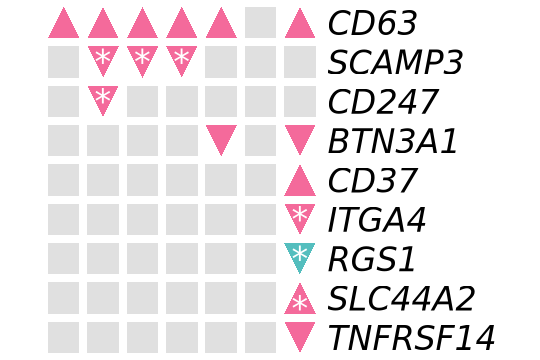

In [261]:
## heatmap
options(repr.plot.width=2.7, repr.plot.height=1.8, repr.plot.res=200)
c0 = "#E0E0E0" # null
c1 = '#54bebe' # shared with sc
c2 = '#f46a9b' # novel in ibsep
c3 = '#7FAFD2' # shared in 1k1k
c4 = '#F69541' # ibsep novel in 1k1k
c5 = '#6495ED' # only in sc
text_color = '#FFFFFF'
col_fun = colorRamp2(c(0, 1, 2, 3), c(c0, c1, c2, c5))
colors = structure(c(c0, c1, c2, c4), names = c(0,1,2,3))
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE, row_order=c(3,4,2,1,5,6,7,8,9),
        cell_fun = function(j, i, x, y, width, height, fill) {
            if(mat[i, j]==0){
                grid.rect(x=x, y=y, width=unit(4, 'mm'), height=unit(4, 'mm'),
                         gp = gpar(fill = c0, col = NA))
            }else if(mat[i, j]>0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                if((mat[i, j]==1) | (mat[i, j]==10)){
                    color = col_fun(1)
                }else if((mat[i, j]==2) | (mat[i, j]==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]>=10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)-1.2,'mm'), gp=gpar(col=text_color))
                }    
            }else if(mat[i, j]<0){
                x1 = unit(as.numeric(x)*as.numeric(w)-2,'mm')
                x2 = unit(as.numeric(x)*as.numeric(w)+2,'mm')
                x3 = unit(as.numeric(x)*as.numeric(w),'mm')
                y1 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y2 = unit(as.numeric(y)*as.numeric(h)+2,'mm')
                y3 = unit(as.numeric(y)*as.numeric(h)-2,'mm')
                if((abs(mat[i, j])==1) | (abs(mat[i, j])==10)){
                    color = col_fun(1)
                }else if((abs(mat[i, j])==2) | (abs(mat[i, j])==20)){
                    color = col_fun(2)
                }else{
                    color = col_fun(3)
                }
                grid.polygon(x=c(x1, x2, x3), y=c(y1, y2, y3), default.units='mm',
                             gp = gpar(fill = color, col = NA))
                if(mat[i, j]<=-10){
                    grid.text('*', x=x, y=unit(as.numeric(y)*as.numeric(h)+0.1,'mm'), gp=gpar(col=text_color))
                }    
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(pbmc_neutro_ibsep_sc_egenes, which='row', 
                                                          gp = gpar(fontsize = 12, fontfamily='ArialMT', fontface = "italic"))),
        width = w, height = h, column_gap = unit(0, "mm"), border = FALSE, show_column_names=FALSE,
        show_heatmap_legend=FALSE
        )
draw(ht)

# Locuszoomr

## ZFP90: CD4

In [131]:
ct = 'CD4T'
gene = 'ZFP90'
gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
mol_id = gene_id_map[gene_id_map$GENENAME==gene]$MOLID
for(chr in 1:22){
    if(file.exists(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct))){
        gene_chr = chr
        break
    }
}
gene_chr
gene_id
mol_id

[1] 16

[1] "ENSG00000184939"

[1] "ILMN_1684628"

In [132]:
eqtl_df2 = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [133]:
dim(eqtl_df2)
min(eqtl_df2$BP)
max(eqtl_df2$BP)
eqtl_df2$CHR[1]
eqtl_df2[eqtl_df2$PVAL==min(eqtl_df2$PVAL)]$SNP
eqtl_df2[eqtl_df2$PVAL_BLUE==min(eqtl_df2$PVAL_BLUE)]$SNP

[1] 319  15

[1] 68488218

[1] 68684500

[1] 16

[1] "rs1170439"

[1] "rs1170439"

In [ ]:
subct = 'cd4nc'
onek1k_all = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M/merged_sumstats/sub_celltypes/%s.txt.gz', subct), sep='\t')
onek1k_df = onek1k_all[onek1k_all$GENEID_1M==gene_id] %>%
    dplyr::filter(!is.na(PVAL_1K1K)) %>%
    dplyr::filter(ROUND_1K1K==1)
dim(onek1k_df)

In [137]:
loc_eqtl2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL', xrange=c(68488218, 68684500), index='rs1170439', seqname=16, ens_db = "EnsDb.Hsapiens.v75")
loc_eqtl2 <- link_LD(loc_eqtl2, token = "7be0fab0c5d8")

rs1170439, chromosome 16, position 68488218 to 68684500

317 SNPs/datapoints

Obtaining LD on 317 SNPs


In [138]:
loc_ibsep2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL_BLUE', xrange=c(68488218, 68684500), index='rs1170439', seqname=16, ens_db = "EnsDb.Hsapiens.v75")
loc_ibsep2 <- link_LD(loc_ibsep2, token = "7be0fab0c5d8")

rs1170439, chromosome 16, position 68488218 to 68684500

317 SNPs/datapoints

Obtaining LD on 317 SNPs


In [139]:
loc_1k1k <- locus(data=onek1k_df, chrom='CHR', pos='BP', p='PVAL_1K1K', labs='SNP_1M', xrange=c(68488218, 68684500), index='rs1170439', seqname=16, ens_db = "EnsDb.Hsapiens.v75")
loc_1k1k <- link_LD(loc_1k1k, token = "7be0fab0c5d8")

rs1170439, chromosome 16, position 68488218 to 68684500

317 SNPs/datapoints

Obtaining LD on 317 SNPs


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


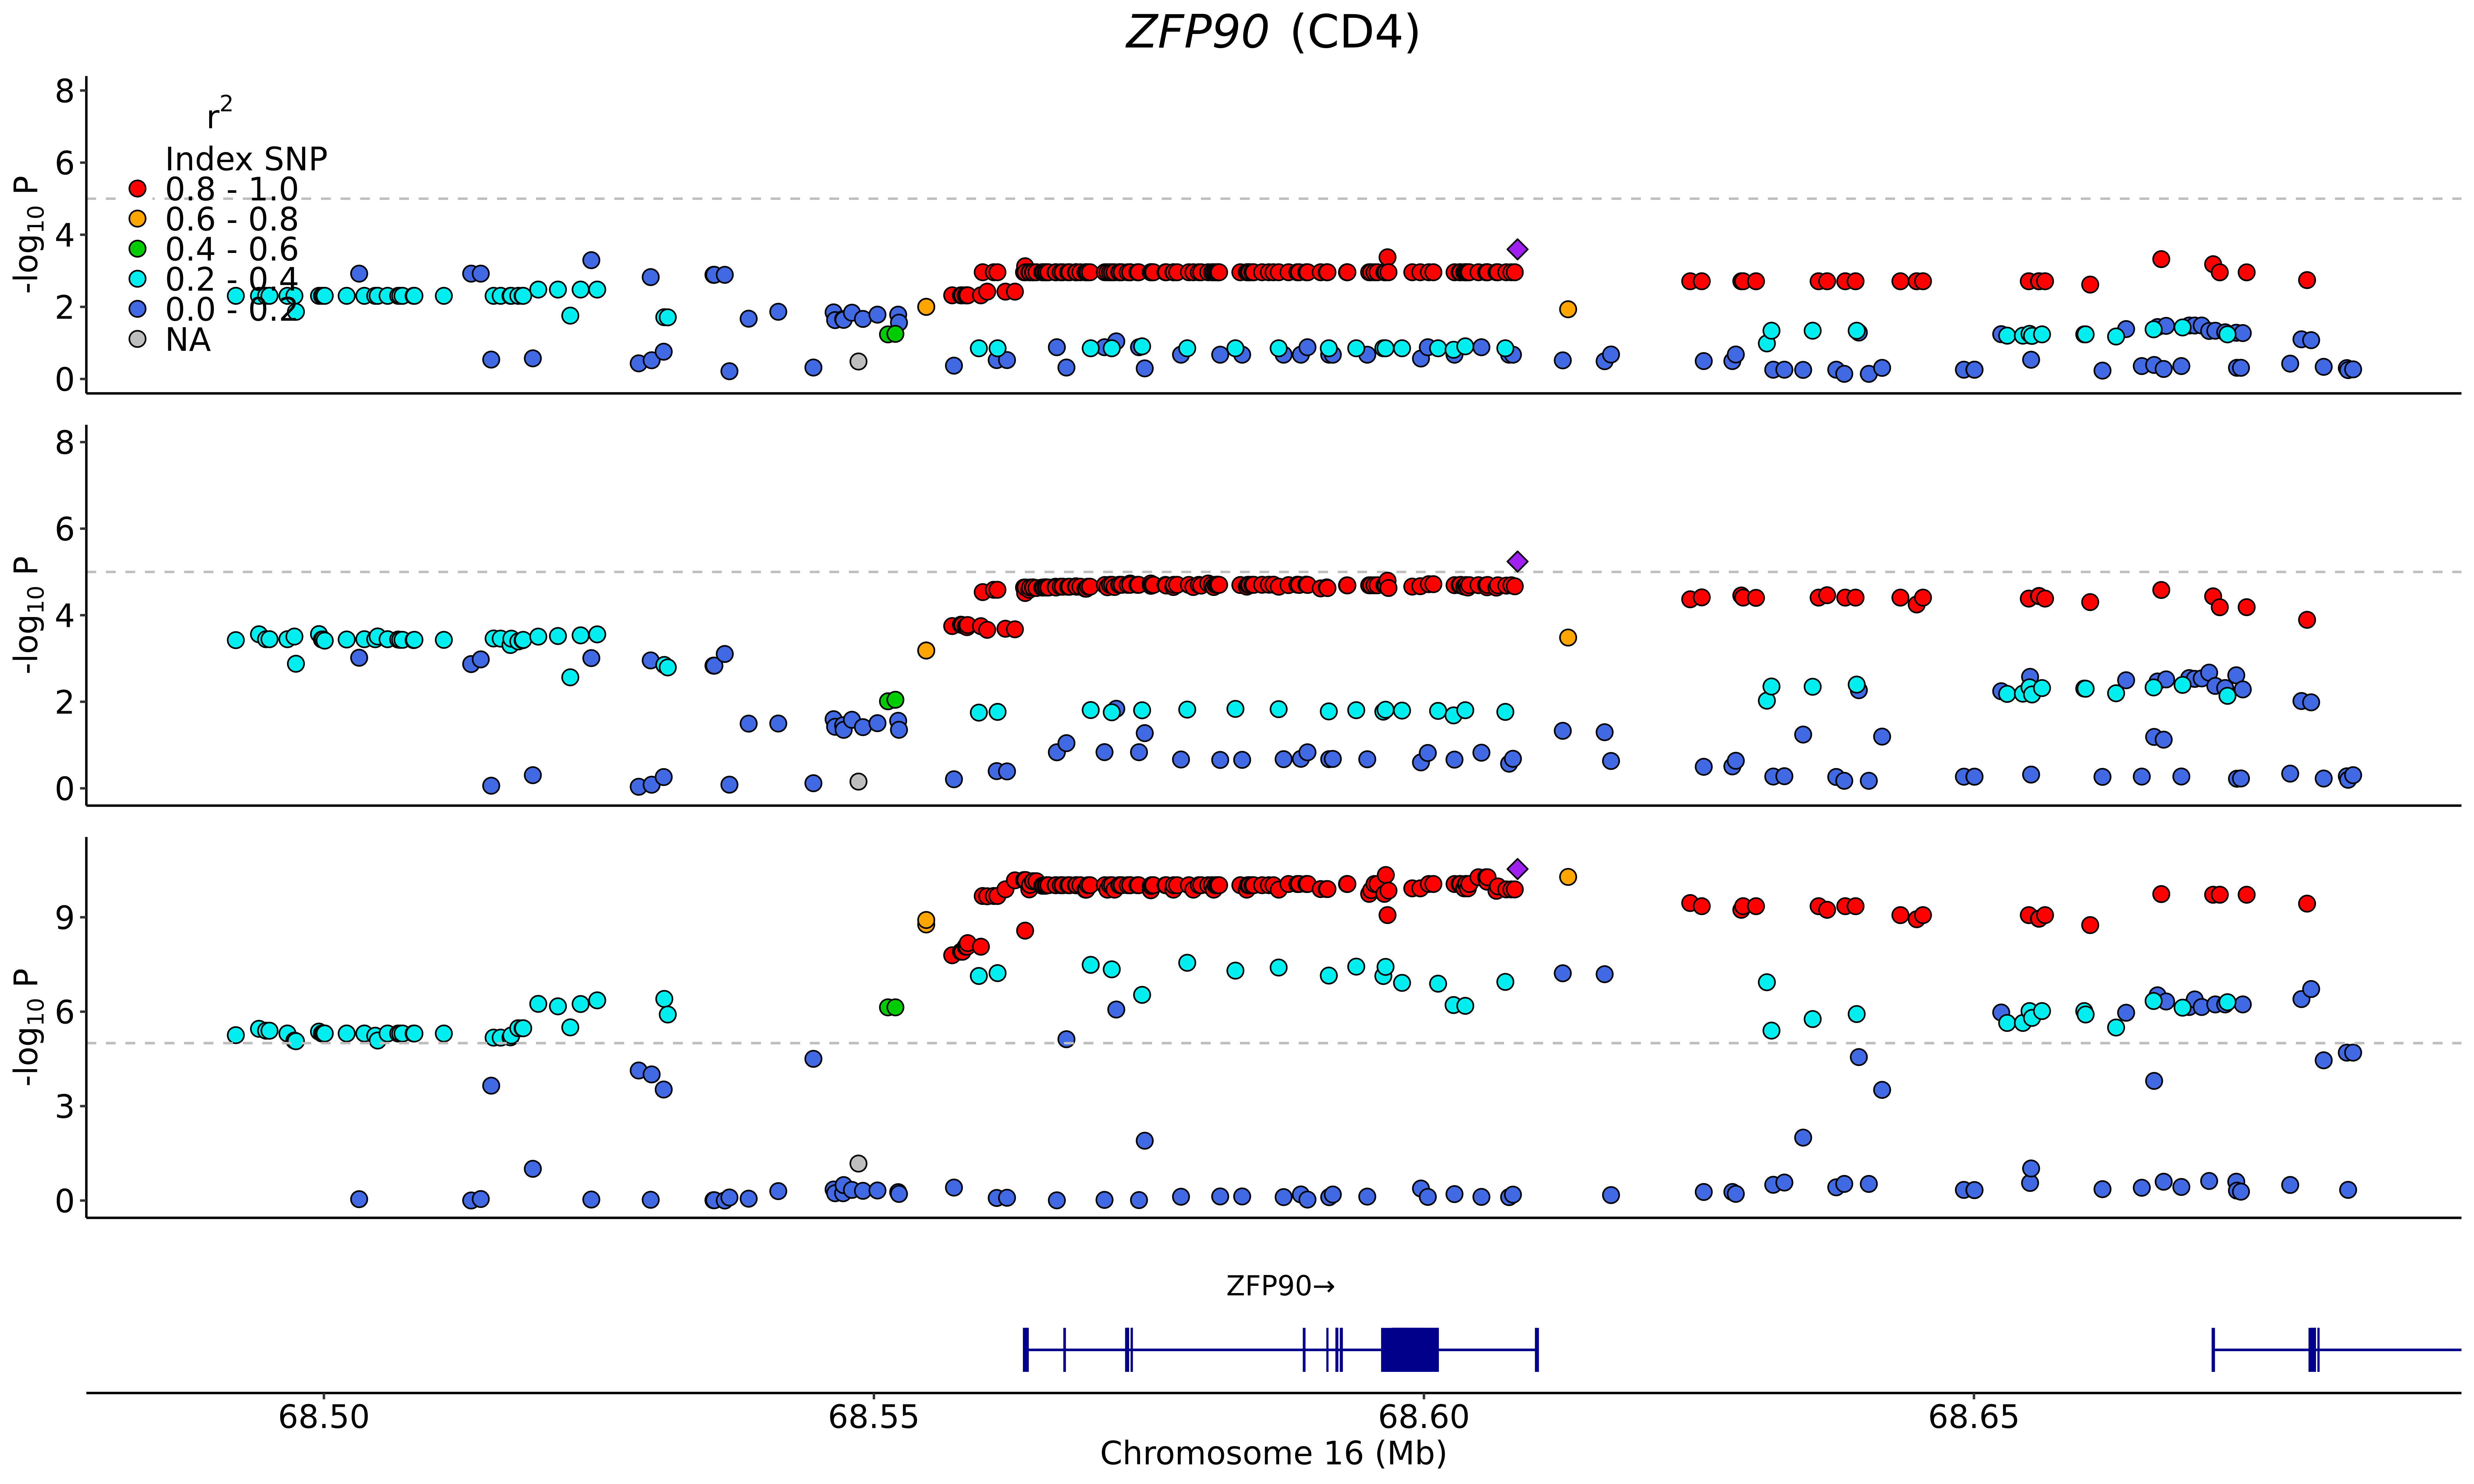

In [140]:
options(repr.plot.width=15, repr.plot.height=9, repr.plot.res=500)
ymax = 8
ymax2 = 11
ycut = 5
text_size = 14
axis_size = 18
title_size = 20
s = 3
p1 <- gg_scatter(loc_eqtl2, labels=NULL, xticks = FALSE, legend_pos='topleft', size=s, pcutoff=1e-5) + ggtitle(expression(paste(italic('ZFP90'), ' (CD4)'))) + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size), plot.title = element_text(color="black", size=title_size, hjust=0.5),
          legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep2, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p3 <- gg_scatter(loc_1k1k, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) +  ylim(c(0, ymax2)) +
    geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep2, maxrows=3, filter_gene_biotype='protein_coding', cex.text=1.0) + 
    theme(axis.text.x=element_text(size=text_size), axis.title.x=element_text(size=text_size))

plot_grid(p1, p2, p3, g, ncol = 1, rel_heights = c(2.5, 2.5, 2.5, 1.5), align = "v")

## ZFP90: NK

In [141]:
ct = 'NK'
gene = 'ZFP90'
gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
mol_id = gene_id_map[gene_id_map$GENENAME==gene]$MOLID
for(chr in 1:22){
    if(file.exists(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct))){
        gene_chr = chr
        break
    }
}
gene_chr
gene_id
mol_id

[1] 16

[1] "ENSG00000184939"

[1] "ILMN_1684628"

In [142]:
eqtl_df2 = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [143]:
dim(eqtl_df2)
min(eqtl_df2$BP)
max(eqtl_df2$BP)
eqtl_df2$CHR[1]
eqtl_df2[eqtl_df2$PVAL==min(eqtl_df2$PVAL)]$SNP
eqtl_df2[eqtl_df2$PVAL_BLUE==min(eqtl_df2$PVAL_BLUE)]$SNP

[1] 319  15

[1] 68488218

[1] 68684500

[1] 16

[1] "rs1645936"

[1] "rs1645936"

In [ ]:
subct = 'nk'
onek1k_all = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M/merged_sumstats/sub_celltypes/%s.txt.gz', subct), sep='\t')
onek1k_df = onek1k_all[onek1k_all$GENEID_1M==gene_id] %>%
    dplyr::filter(!is.na(PVAL_1K1K)) %>%
    dplyr::filter(ROUND_1K1K==1)

In [147]:
loc_eqtl2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL', xrange=c(68488218, 68684500), index='rs1645936', seqname=16, ens_db = "EnsDb.Hsapiens.v75")
loc_eqtl2 <- link_LD(loc_eqtl2, token = "7be0fab0c5d8")

rs1645936, chromosome 16, position 68488218 to 68684500

317 SNPs/datapoints

Obtaining LD on 317 SNPs


In [148]:
loc_ibsep2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL_BLUE', xrange=c(68488218, 68684500), index='rs1645936', seqname=16, ens_db = "EnsDb.Hsapiens.v75")
loc_ibsep2 <- link_LD(loc_ibsep2, token = "7be0fab0c5d8")

rs1645936, chromosome 16, position 68488218 to 68684500

317 SNPs/datapoints

Obtaining LD on 317 SNPs


In [149]:
loc_1k1k <- locus(data=onek1k_df, chrom='CHR', pos='BP', p='PVAL_1K1K', labs='SNP_1M', xrange=c(68488218, 68684500), index='rs1645936', seqname=16, ens_db = "EnsDb.Hsapiens.v75")
loc_1k1k <- link_LD(loc_1k1k, token = "7be0fab0c5d8")

rs1645936, chromosome 16, position 68488218 to 68684500

317 SNPs/datapoints

Obtaining LD on 317 SNPs


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


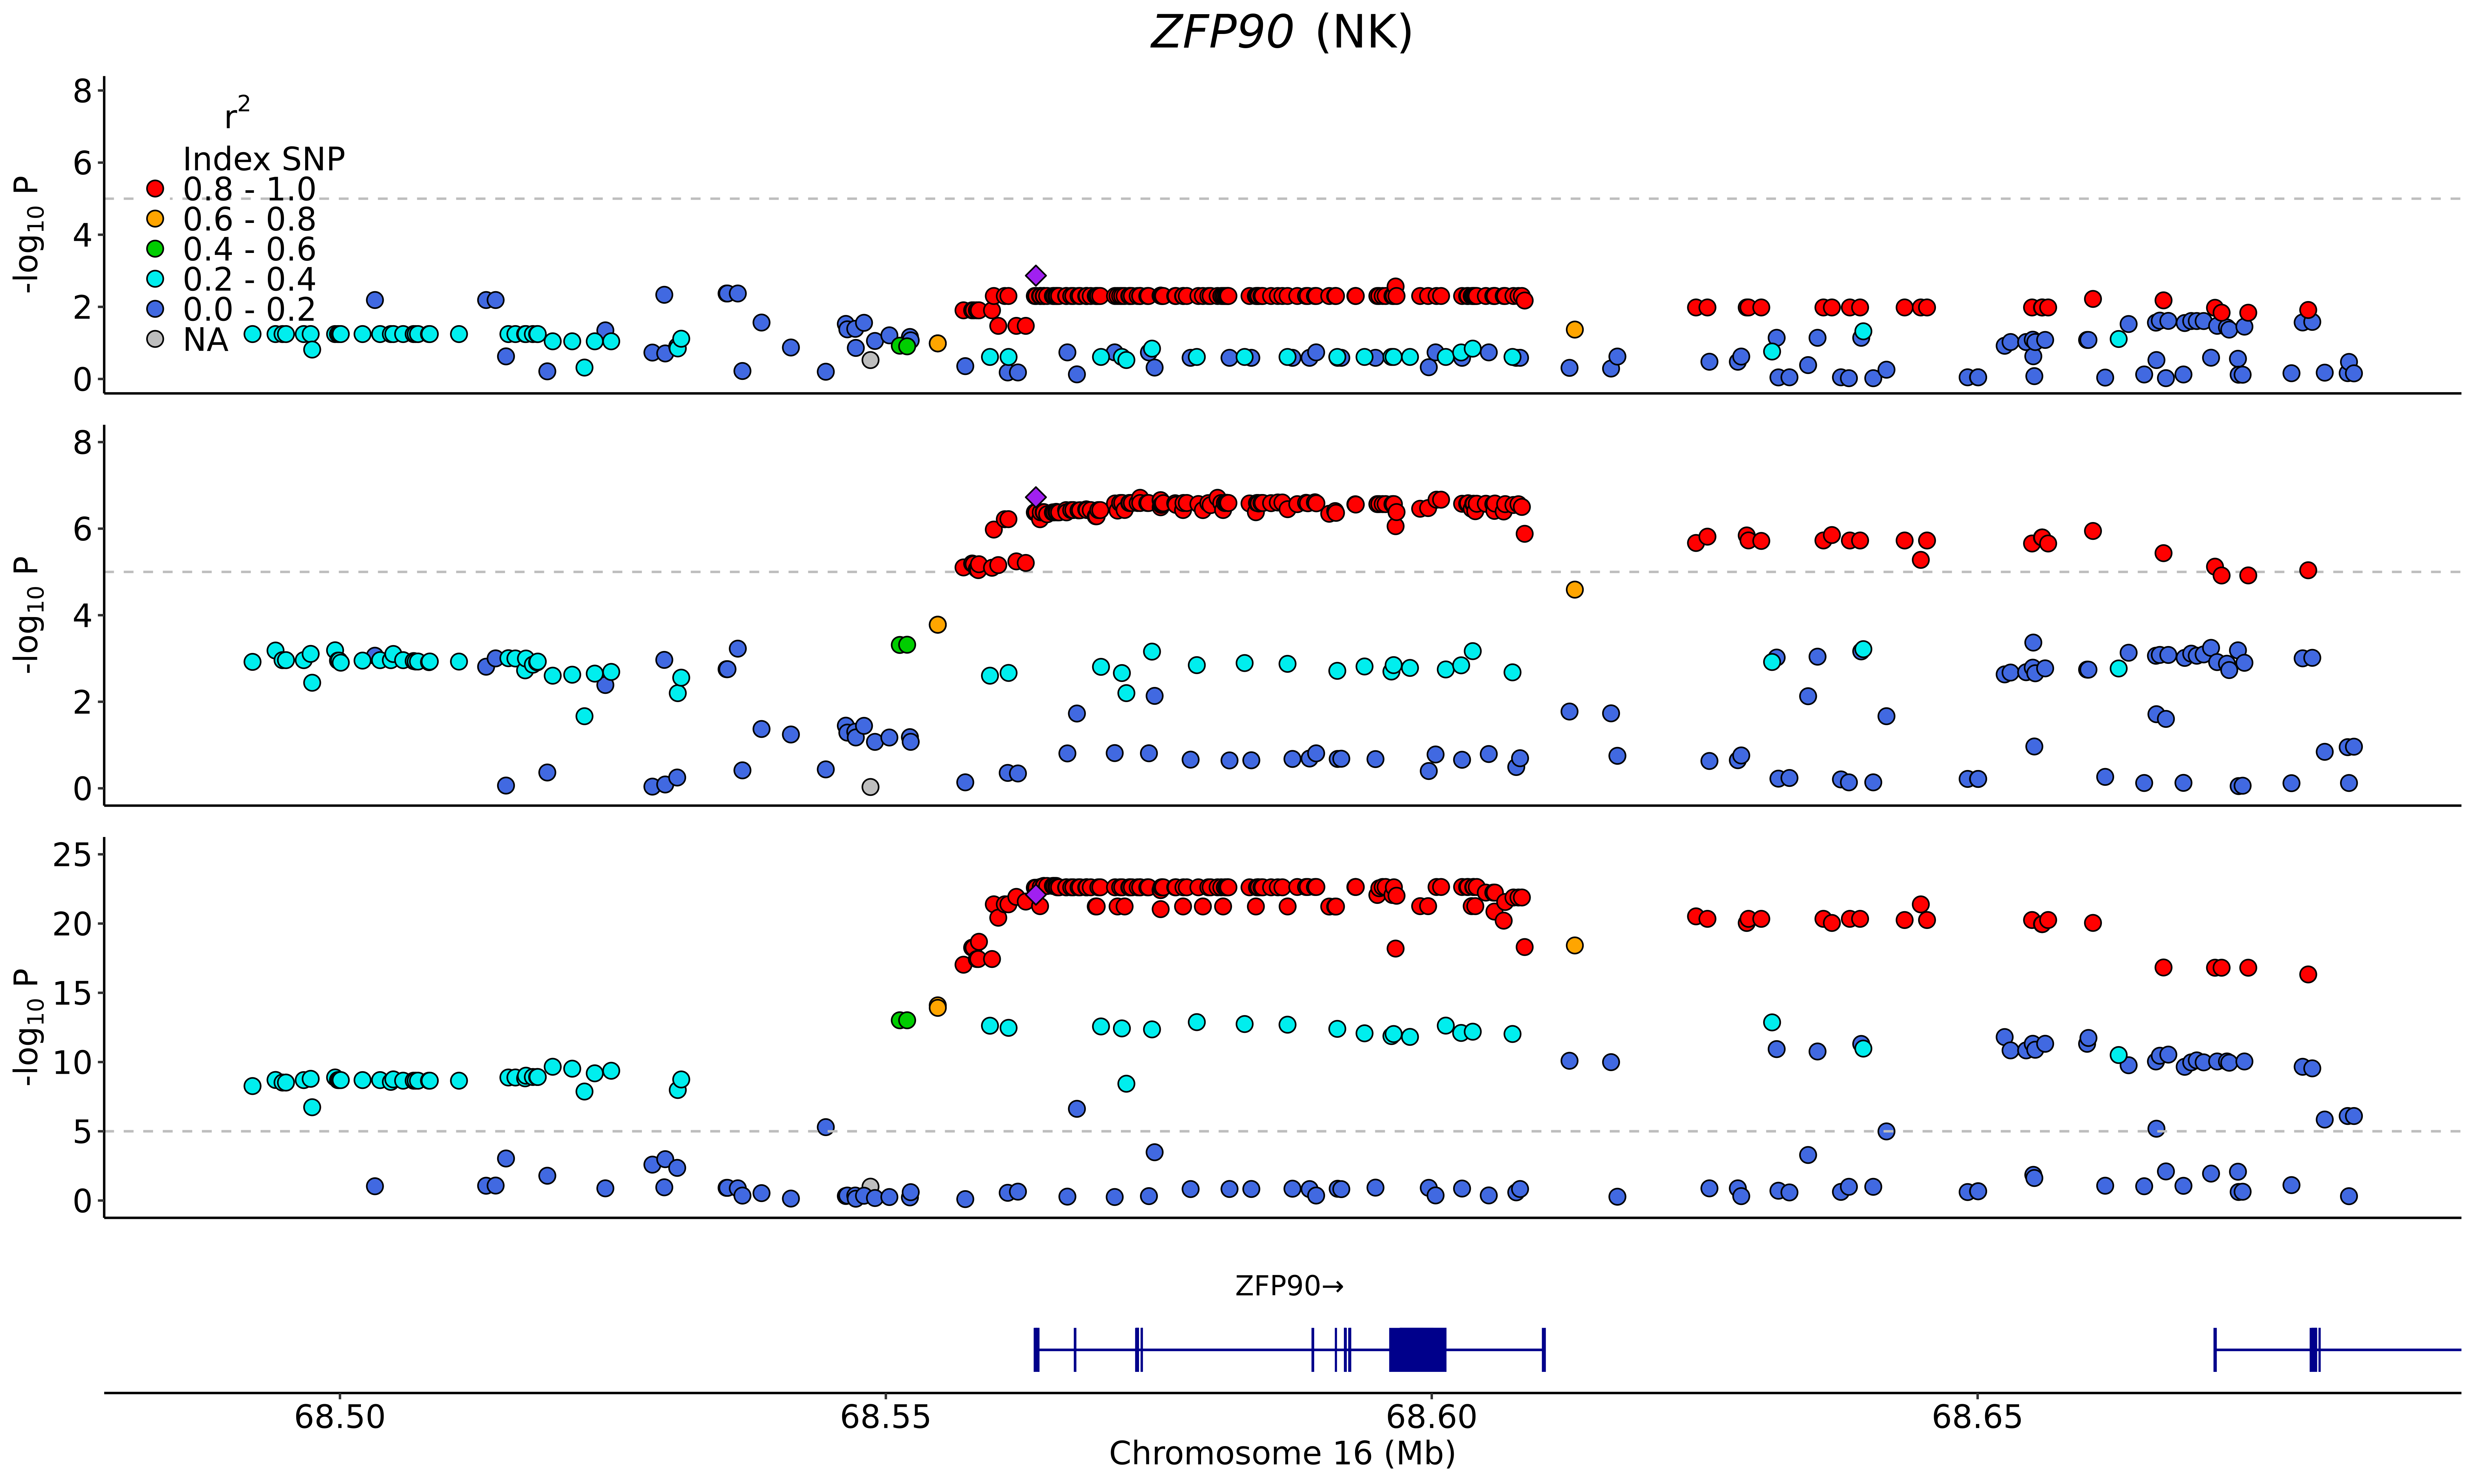

In [150]:
options(repr.plot.width=15, repr.plot.height=9, repr.plot.res=500)
ymax = 8
ymax2 = 25
ycut = 5
text_size = 14
axis_size = 18
title_size = 20
s = 3
p1 <- gg_scatter(loc_eqtl2, labels=NULL, xticks = FALSE, legend_pos='topleft', size=s, pcutoff=1e-5) + ggtitle(expression(paste(italic('ZFP90'), ' (NK)'))) + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size), plot.title = element_text(color="black", size=title_size, hjust=0.5),
          legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep2, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p3 <- gg_scatter(loc_1k1k, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) +  ylim(c(0, ymax2)) +
    geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep2, maxrows=3, filter_gene_biotype='protein_coding', cex.text=1.0) + 
    theme(axis.text.x=element_text(size=text_size), axis.title.x=element_text(size=text_size))

plot_grid(p1, p2, p3, g, ncol = 1, rel_heights = c(2.5, 2.5, 2.5, 1.5), align = "v")

## PPP5C: NK

In [120]:
ct = 'NK'
gene = 'PPP5C'
gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
mol_id = gene_id_map[gene_id_map$GENENAME==gene]$MOLID
for(chr in 1:22){
    if(file.exists(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct))){
        gene_chr = chr
        break
    }
}
gene_chr
gene_id
mol_id

[1] 19

[1] "ENSG00000011485"

[1] "ILMN_1745332"

In [121]:
eqtl_df2 = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [122]:
dim(eqtl_df2)
min(eqtl_df2$BP)
max(eqtl_df2$BP)
eqtl_df2$CHR[1]
eqtl_df2[eqtl_df2$PVAL==min(eqtl_df2$PVAL)]$SNP
eqtl_df2[eqtl_df2$PVAL_BLUE==min(eqtl_df2$PVAL_BLUE)]$SNP

[1] 362  15

[1] 46774360

[1] 46972967

[1] 19

[1] "rs62136099"

[1] "rs62136101"

In [ ]:
subct = 'nk'
onek1k_all = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M/merged_sumstats/sub_celltypes/%s.txt.gz', subct), sep='\t')
onek1k_df = onek1k_all[onek1k_all$GENEID_1M==gene_id] %>%
    dplyr::filter(!is.na(PVAL_1K1K)) %>%
    dplyr::filter(ROUND_1K1K==1)

In [126]:
loc_eqtl2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL', xrange=c(46774360, 46972967), index='rs62136101', seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_eqtl2 <- link_LD(loc_eqtl2, token = "7be0fab0c5d8")

rs62136101, chromosome 19, position 46774360 to 46972967

360 SNPs/datapoints

Obtaining LD on 360 SNPs


In [127]:
loc_ibsep2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL_BLUE', xrange=c(46774360, 46972967), index='rs62136101', seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_ibsep2 <- link_LD(loc_ibsep2, token = "7be0fab0c5d8")

rs62136101, chromosome 19, position 46774360 to 46972967

360 SNPs/datapoints

Obtaining LD on 360 SNPs


In [128]:
loc_1k1k <- locus(data=onek1k_df, chrom='CHR', pos='BP', p='PVAL_1K1K', labs='SNP_1M', xrange=c(46774360, 46972967), index='rs62136101', seqname=19, ens_db = "EnsDb.Hsapiens.v75")
loc_1k1k <- link_LD(loc_1k1k, token = "7be0fab0c5d8")

rs62136101, chromosome 19, position 46774360 to 46972967

360 SNPs/datapoints

Obtaining LD on 360 SNPs


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


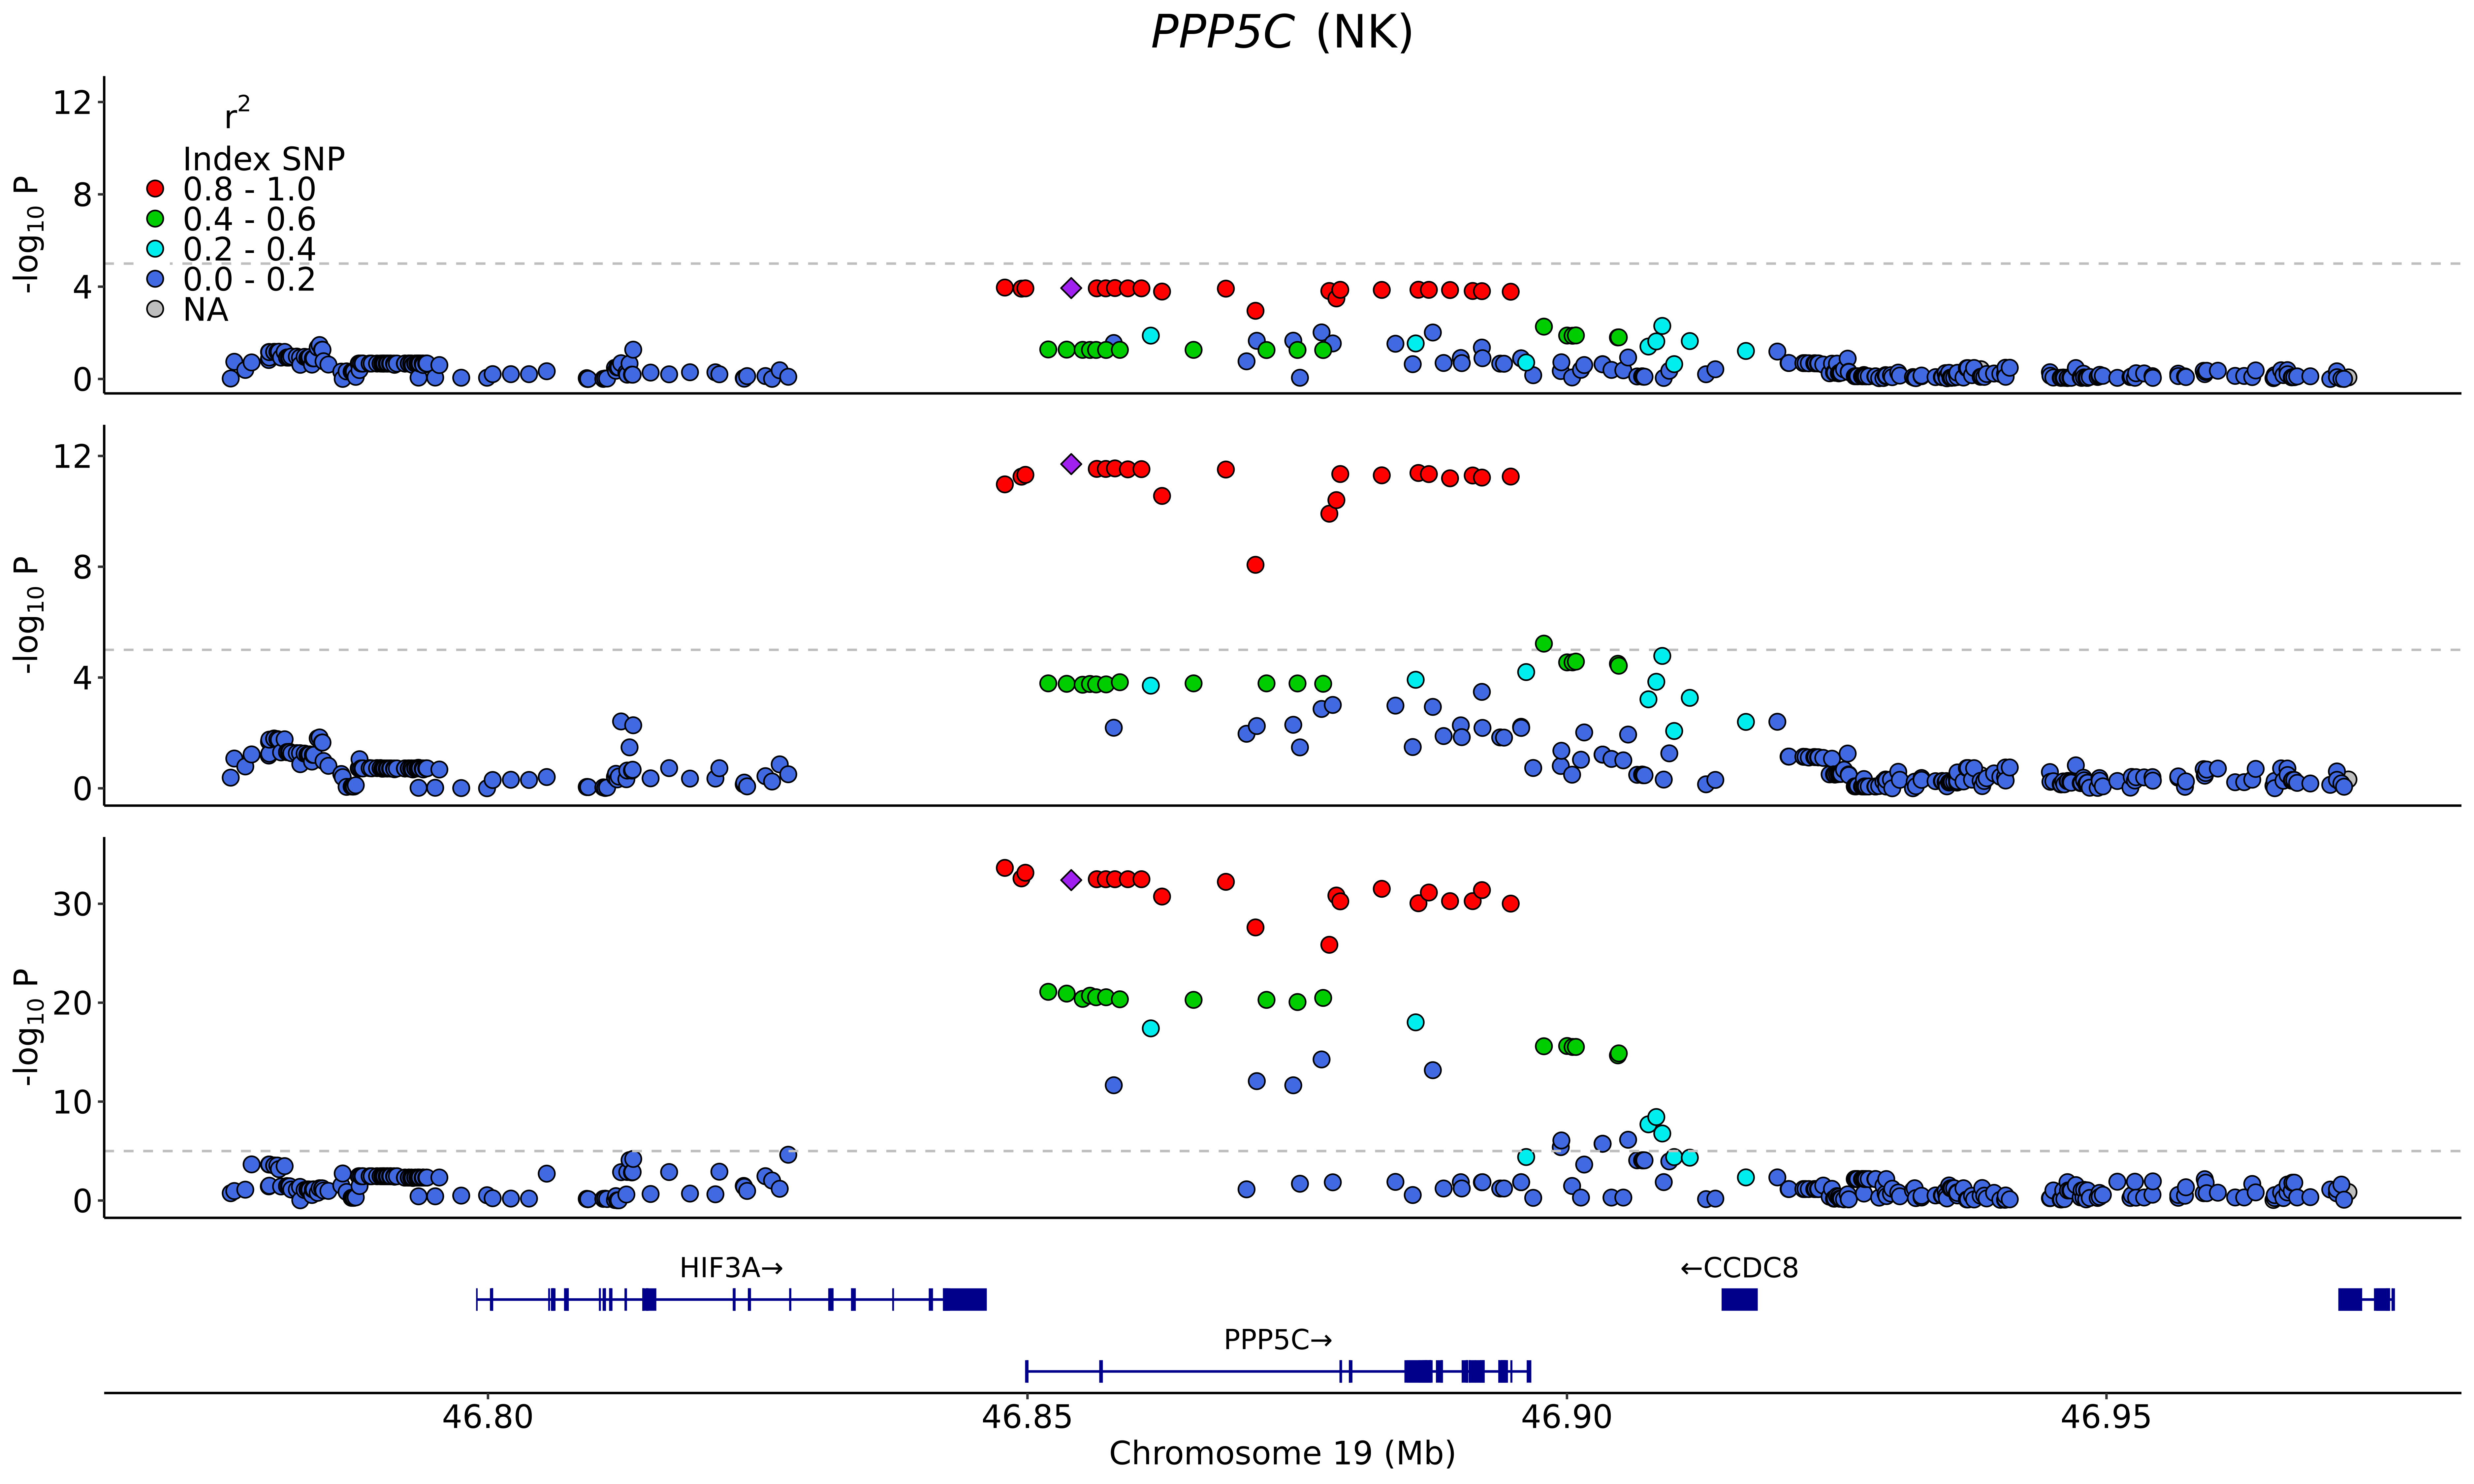

In [130]:
options(repr.plot.width=15, repr.plot.height=9, repr.plot.res=500)
ymax = 12.5
ymax2 = 35
ycut = 5
text_size = 14
axis_size = 18
title_size = 20
s = 3
p1 <- gg_scatter(loc_eqtl2, labels=NULL, xticks = FALSE, legend_pos='topleft', size=s, pcutoff=1e-5) + ggtitle(expression(paste(italic('PPP5C'), ' (NK)'))) + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size), plot.title = element_text(color="black", size=title_size, hjust=0.5),
          legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep2, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p3 <- gg_scatter(loc_1k1k, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) +  ylim(c(0, ymax2)) +
    geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep2, maxrows=3, filter_gene_biotype='protein_coding', cex.text=1.0) + 
    theme(axis.text.x=element_text(size=text_size), axis.title.x=element_text(size=text_size))

plot_grid(p1, p2, p3, g, ncol = 1, rel_heights = c(2.5, 2.5, 2.5, 1.5), align = "v")

## CD247: CD4

In [101]:
ct = 'CD4T'
gene = 'CD247'
gene_id = gene_id_map[gene_id_map$GENENAME==gene]$GENEID
mol_id = gene_id_map[gene_id_map$GENENAME==gene]$MOLID
for(chr in 1:22){
    if(file.exists(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct))){
        gene_chr = chr
        break
    }
}
gene_chr
gene_id
mol_id

[1] 1

[1] "ENSG00000198821"

[1] "ILMN_1676924"

In [102]:
eqtl_df2 = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_%s_max_hsq_%s/chr%s/%s-%s_%s_blue_pval0.0001_tau1.0_truncorr.csv', 
                               omega_shrink, max_hsq, chr, gene_id, mol_id, ct), sep='\t') %>%
            dplyr::filter(!is.na(PVAL_BLUE)) %>%
            dplyr::filter(!is.na(PVAL))

In [104]:
min(eqtl_df2$BP)
max(eqtl_df2$BP)
eqtl_df2$CHR[1]
eqtl_df2[eqtl_df2$PVAL==min(eqtl_df2$PVAL)]$SNP
eqtl_df2[eqtl_df2$PVAL_BLUE==min(eqtl_df2$PVAL_BLUE)]$SNP

[1] 167343995

[1] 167543814

[1] 1

[1] "rs2056626"

[1] "rs7523907"

In [ ]:
subct = 'cd4nc'
onek1k_all = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_data/1M/merged_sumstats/sub_celltypes/%s.txt.gz', subct), sep='\t')
onek1k_df = onek1k_all[onek1k_all$GENEID_1M==gene_id] %>%
    dplyr::filter(!is.na(PVAL_1K1K)) %>%
    dplyr::filter(ROUND_1K1K==1)

In [109]:
loc_eqtl2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL', xrange=c(167343995, 167543814), index='rs7523907', seqname=1, ens_db = "EnsDb.Hsapiens.v75")
loc_eqtl2 <- link_LD(loc_eqtl2, token = "7be0fab0c5d8")

rs7523907, chromosome 1, position 167343995 to 167543814

297 SNPs/datapoints

Obtaining LD on 297 SNPs


In [110]:
loc_ibsep2 <- locus(data=eqtl_df2, chrom='CHR', pos='BP', p='PVAL_BLUE', xrange=c(167343995, 167543814), index='rs7523907', seqname=1, ens_db = "EnsDb.Hsapiens.v75")
loc_ibsep2 <- link_LD(loc_ibsep2, token = "7be0fab0c5d8")

rs7523907, chromosome 1, position 167343995 to 167543814

297 SNPs/datapoints

Obtaining LD on 297 SNPs


In [111]:
loc_1k1k <- locus(data=onek1k_df, chrom='CHR', pos='BP', p='PVAL_1K1K', labs='SNP_1M', xrange=c(167343995, 167543814), index='rs7523907', seqname=1, ens_db = "EnsDb.Hsapiens.v75")
loc_1k1k <- link_LD(loc_1k1k, token = "7be0fab0c5d8")

rs7523907, chromosome 1, position 167343995 to 167543814

298 SNPs/datapoints

Obtaining LD on 298 SNPs


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


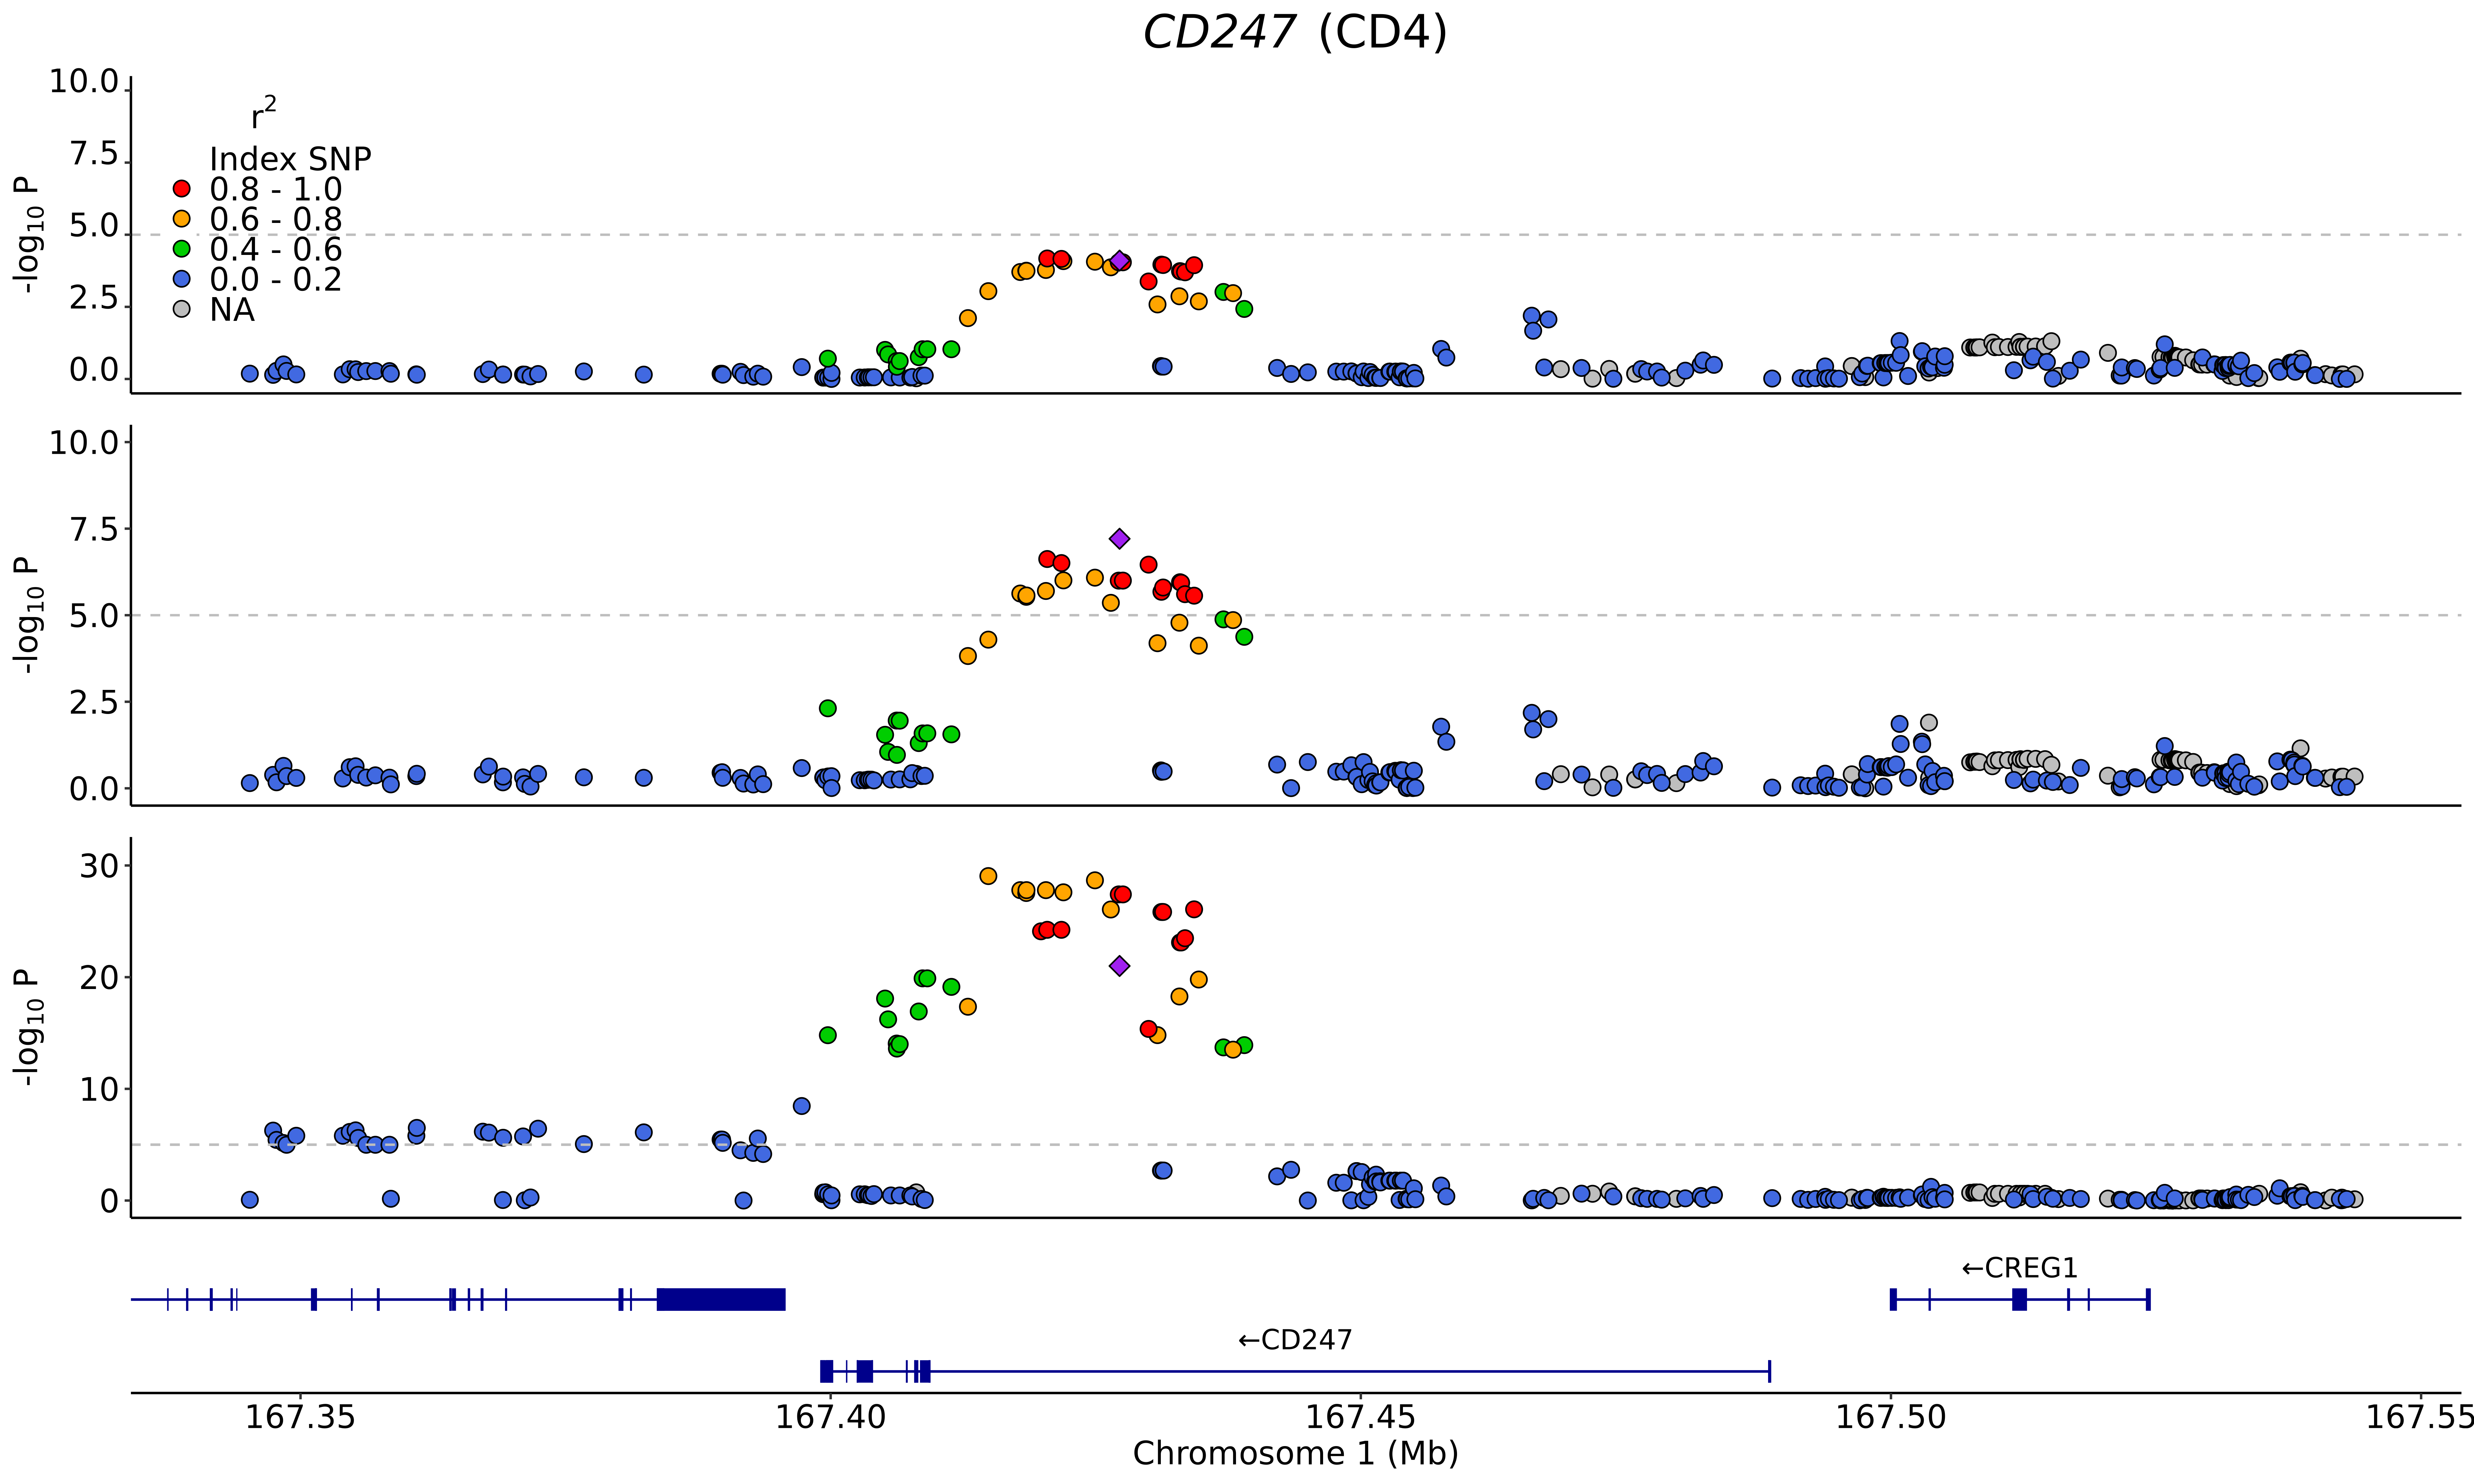

In [119]:
options(repr.plot.width=15, repr.plot.height=9, repr.plot.res=500)
ymax = 10
ymax2 = 31
ycut = 5
text_size = 14
axis_size = 18
title_size = 20
s = 3
p1 <- gg_scatter(loc_eqtl2, labels=NULL, xticks = FALSE, legend_pos='topleft', size=s, pcutoff=1e-5) + ggtitle(expression(paste(italic('CD247'), ' (CD4)'))) + 
    ylim(c(0, ymax)) + geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size), plot.title = element_text(color="black", size=title_size, hjust=0.5),
          legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p2 <- gg_scatter(loc_ibsep2, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) + ylim(c(0, ymax)) + 
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
p3 <- gg_scatter(loc_1k1k, labels=NULL, xticks = FALSE, legend_pos=NULL, size=s, pcutoff=1e-5) +  ylim(c(0, ymax2)) +
    geom_hline(yintercept = ycut, colour = "grey", linetype = "dashed") +
    theme(axis.text=element_text(size=text_size), axis.title=element_text(size=text_size),
         legend.text=element_text(size=text_size), legend.title=element_text(size=text_size), legend.background=element_rect(fill = alpha("white", 0.0)))
g <- gg_genetracks(loc_ibsep2, maxrows=3, filter_gene_biotype='protein_coding', cex.text=1.0) + 
    theme(axis.text.x=element_text(size=text_size), axis.title.x=element_text(size=text_size))

plot_grid(p1, p2, p3, g, ncol = 1, rel_heights = c(2.5, 2.5, 2.5, 1.5), align = "v")